In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras

170498071/170498071 [==============================] - 13s 0us/step


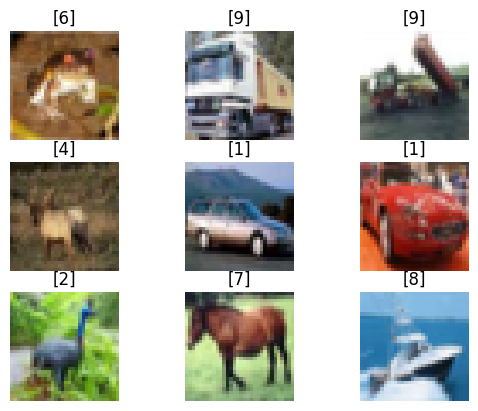

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title(str(y_train[i]))
plt.show()

In [3]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.5,1.1]
    )

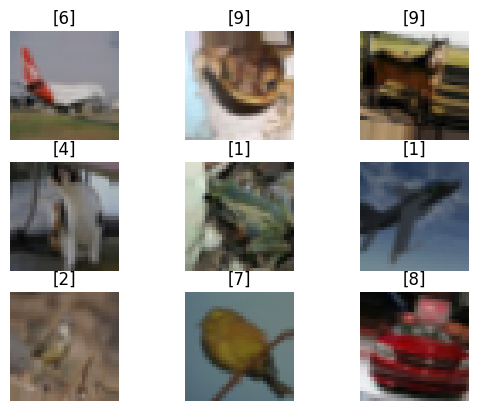

In [4]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
        plt.axis('off')
        plt.title(str(y_train[i]))
    plt.show()
    break

In [5]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [6]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [7]:

x_train, val_images, y_train,  val_labels = train_test_split(x_train, y_train, test_size = 0.1)


In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples


In [8]:
# plotting helper function
def plothist(hist):
    #plt.subplot(211)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

    #plt.subplot(212)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

In [9]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(learning_rate=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [12]:
# train with image augmentation
history=model.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(val_images, val_labels), steps_per_epoch =int(x_train.shape[0] / 64), epochs=70, verbose=1)

Epoch 1/70
703/703 [==============================] - 66s 82ms/step - loss: 1.7462 - accuracy: 0.4194 - val_loss: 1.2394 - val_accuracy: 0.5750
Epoch 2/70
703/703 [==============================] - 59s 84ms/step - loss: 1.1304 - accuracy: 0.6004 - val_loss: 0.9477 - val_accuracy: 0.6842
Epoch 3/70
703/703 [==============================] - 57s 80ms/step - loss: 0.9370 - accuracy: 0.6722 - val_loss: 0.8461 - val_accuracy: 0.7130
Epoch 4/70
703/703 [==============================] - 55s 79ms/step - loss: 0.8333 - accuracy: 0.7075 - val_loss: 0.7664 - val_accuracy: 0.7376
Epoch 5/70
703/703 [==============================] - 56s 80ms/step - loss: 0.7614 - accuracy: 0.7364 - val_loss: 0.6602 - val_accuracy: 0.7746
Epoch 6/70
703/703 [==============================] - 55s 78ms/step - loss: 0.7008 - accuracy: 0.7560 - val_loss: 0.7053 - val_accuracy: 0.7626
Epoch 7/70
703/703 [==============================] - 55s 78ms/step - loss: 0.6629 - accuracy: 0.7709 - val_loss: 0.6174 - val_accuracy:

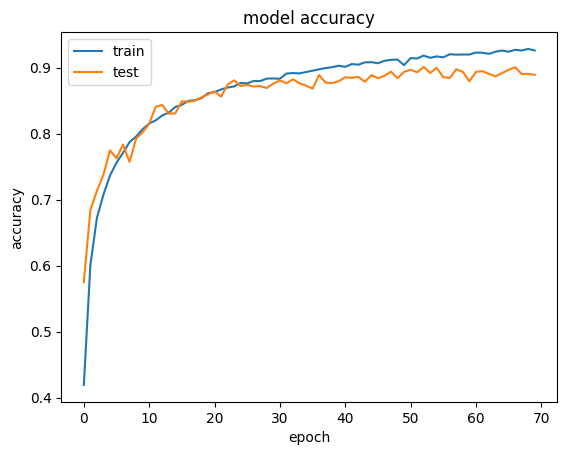

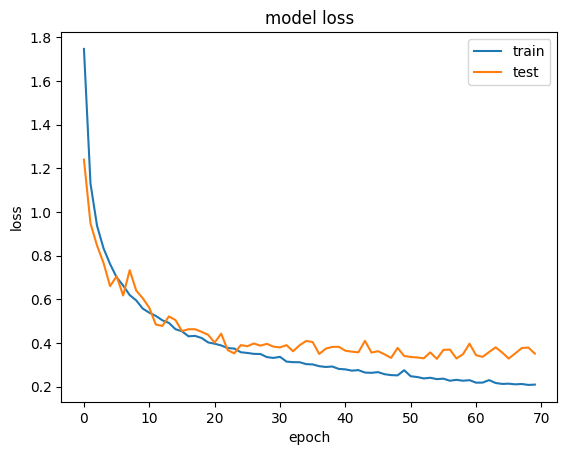

In [33]:
plothist(history)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
model.save('/content/drive/MyDrive/cifar_model/cifar10_model_DataAug_70Epoch.h5')

In [33]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/cifar_model/cifar10_model_DataAug_70Epoch.h5')

In [16]:
model_train_acc = model.evaluate(x_train,y_train,batch_size=64)
model_train_acc

704/704 [==============================] - 5s 8ms/step - loss: 0.1194 - accuracy: 0.9586


[0.11936376988887787, 0.9585555791854858]

In [17]:
test_acc = model.evaluate(x_test, y_test, batch_size=64)
print(' Test Accuracy For Desisgned Model' , test_acc[1])

157/157 [==============================] - 1s 6ms/step - loss: 0.3841 - accuracy: 0.8818
 Test Accuracy For Desisgned Model 0.8817999958992004


In [28]:
print('difference between train and test accuracy in epoch (70) is :' , (0.9585555791854858 - 0.8817999958992004) * 100)

difference between train and test accuracy in epoch (70) is : 7.67555832862854


### همان طور که دیده می شود تقریبا در محدوده ایپاک 25، نمودار از حالت فیت بودن دقت و لاس در ترین و تست به اورفیتینگ میل پیدا می کند
###  هم در نمودار قت و هم در نمودار  لاس نقطه موردنظر 25 هست
### ضمن اینکه با اولیوایت کردن مدل بر روی داده های تست و مجددا داده های ترین می بینیم که اختلاف دقت بیشتر از 5 هست

### و مجدد مدل را با ایپاک 25 ترین می کنیم و نتیجه را بررسی می کنیم

In [10]:
# train with image augmentation and epoch = 25
history2 = model.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(val_images, val_labels), steps_per_epoch =int(x_train.shape[0] / 64), epochs=25, verbose=1)


Epoch 1/25
703/703 [==============================] - 64s 75ms/step - loss: 1.7258 - accuracy: 0.4244 - val_loss: 1.3207 - val_accuracy: 0.5458
Epoch 2/25
703/703 [==============================] - 45s 63ms/step - loss: 1.1353 - accuracy: 0.6004 - val_loss: 0.9288 - val_accuracy: 0.6800
Epoch 3/25
703/703 [==============================] - 43s 61ms/step - loss: 0.9414 - accuracy: 0.6710 - val_loss: 0.7986 - val_accuracy: 0.7228
Epoch 4/25
703/703 [==============================] - 45s 64ms/step - loss: 0.8380 - accuracy: 0.7074 - val_loss: 0.7835 - val_accuracy: 0.7354
Epoch 5/25
703/703 [==============================] - 44s 62ms/step - loss: 0.7524 - accuracy: 0.7369 - val_loss: 0.6765 - val_accuracy: 0.7712
Epoch 6/25
703/703 [==============================] - 44s 63ms/step - loss: 0.7051 - accuracy: 0.7558 - val_loss: 0.6166 - val_accuracy: 0.7912
Epoch 7/25
703/703 [==============================] - 44s 63ms/step - loss: 0.6660 - accuracy: 0.7714 - val_loss: 0.6051 - val_accuracy:

In [11]:
model_train_acc2 = model.evaluate(x_train,y_train,batch_size=64)
model_train_acc2

704/704 [==============================] - 3s 4ms/step - loss: 0.2532 - accuracy: 0.9126


[0.2532109022140503, 0.9126222133636475]

In [20]:
test_acc2 = model.evaluate(x_test, y_test, batch_size=64)
print(' Test Accuracy For Desisgned Model with epoch (25) is : ' , test_acc2[1])

157/157 [==============================] - 1s 5ms/step - loss: 0.3716 - accuracy: 0.8782
 Test Accuracy For Desisgned Model with epoch (25) is :  0.8781999945640564


In [26]:
print('difference between train and test accuracy in epoch (25) is :' , (model_train_acc2[1] - test_acc2[1]) * 100)

difference between train and test accuracy in epoch (25) is : 3.4422218799591064


###  با اولیوایت کردن مدل بر روی داده های تست و مجددا داده های ترین می بینیم که اختلاف دقت کمتر از 5 شد و به نتیجه مطلوب رسیدیم که اختلاف اموزش با داده های ترین و تست کمتر شد پس ایپاک مناسب تر می تواند 25 باشد

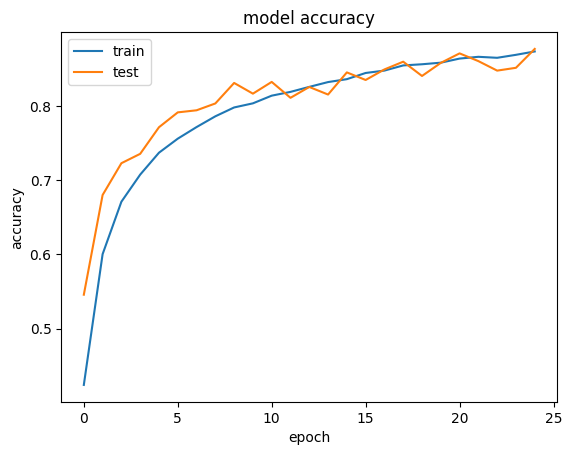

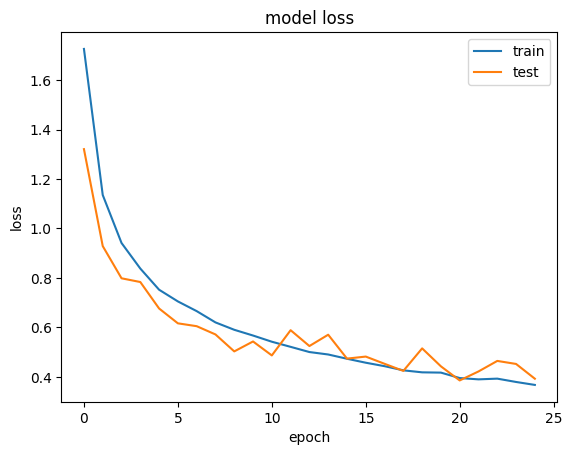

In [13]:
plothist(history2)

### براساس نمودارهای جدید بدست امده می تواند ایچاپ 15 هم موردبررسی قرارگیرد که با این ایچاک نتیجه اختلاف دقت ترین و تست چگونه خواهد بود که این مورد در ادامه بررسی می شود

In [14]:
# train with image augmentation and epoch = 25
history3 = model.fit(datagen.flow(x_train, y_train, batch_size=64), validation_data=(val_images, val_labels), steps_per_epoch =int(x_train.shape[0] / 64), epochs=15, verbose=1)


Epoch 1/15
703/703 [==============================] - 45s 64ms/step - loss: 0.3560 - accuracy: 0.8756 - val_loss: 0.4073 - val_accuracy: 0.8714
Epoch 2/15
703/703 [==============================] - 46s 65ms/step - loss: 0.3544 - accuracy: 0.8760 - val_loss: 0.3909 - val_accuracy: 0.8744
Epoch 3/15
703/703 [==============================] - 58s 83ms/step - loss: 0.3439 - accuracy: 0.8813 - val_loss: 0.4327 - val_accuracy: 0.8628
Epoch 4/15
703/703 [==============================] - 46s 66ms/step - loss: 0.3426 - accuracy: 0.8806 - val_loss: 0.3939 - val_accuracy: 0.8700
Epoch 5/15
703/703 [==============================] - 47s 66ms/step - loss: 0.3373 - accuracy: 0.8827 - val_loss: 0.4351 - val_accuracy: 0.8634
Epoch 6/15
703/703 [==============================] - 44s 62ms/step - loss: 0.3269 - accuracy: 0.8850 - val_loss: 0.4361 - val_accuracy: 0.8612
Epoch 7/15
703/703 [==============================] - 44s 62ms/step - loss: 0.3209 - accuracy: 0.8888 - val_loss: 0.4345 - val_accuracy:

In [23]:
model_train_acc3 = model.evaluate(x_train,y_train,batch_size=64)
model_train_acc3

704/704 [==============================] - 3s 4ms/step - loss: 0.1679 - accuracy: 0.9412


[0.16786065697669983, 0.9412222504615784]

In [21]:
test_acc3 = model.evaluate(x_test, y_test, batch_size=64)
print(' Test Accuracy For Desisgned Model with epoch (15) is : ' , test_acc3[1])

157/157 [==============================] - 1s 5ms/step - loss: 0.3716 - accuracy: 0.8782
 Test Accuracy For Desisgned Model with epoch (15) is :  0.8781999945640564


In [27]:
print('difference between train and test accuracy in epoch (15) is :' , (model_train_acc3[1] - test_acc3[1]) * 100)

difference between train and test accuracy in epoch (15) is : 6.302225589752197


### همان طور که مشاهده می شود با این ایپاک اختلاف ترین و تست زیاد می شود بنابراین ایپاک 25 نتیجه نهایی خواهد بود